In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <gsl/gsl_blas.h>
#include <gsl/gsl_blas_types.h>
#include <gsl/gsl_vector.h>
#include <time.h>
#include <sys/time.h>
#include <sys/types.h>
#include <stdint.h>

uint64_t ddot(size_t n) {
    gsl_vector * x;
    gsl_vector * y;
    int i;
    uint64_t res;
    double * result;
    struct timespec start, end;

    result = (double*) malloc (sizeof(double));
    x = gsl_vector_alloc(n);
    y = gsl_vector_alloc(n);

    for(i = 0; i < n; i++) {
        gsl_vector_set(x, i, (double) i);
        gsl_vector_set(y, i, (double) i);
    }
    clock_gettime(0, &start);
    gsl_blas_ddot(x, y, result);
    clock_gettime(0, &end);
    res = (end.tv_sec - start.tv_sec) * 1000000 + (end.tv_nsec - start.tv_nsec) / 1000;
    gsl_vector_free(x);
    gsl_vector_free(y);
    free(result);
    return res;
}

uint64_t dgemv(int n) {
    gsl_matrix * matrix;
    gsl_vector * vector, * result;
    int i, j;
    struct timespec start, end;
    uint64_t res;
    matrix = gsl_matrix_alloc(n, n);
    vector = gsl_vector_alloc(n);
    result = gsl_vector_alloc(n);

    for(i = 0; i < n; i++) {
        gsl_vector_set(vector, i, (double) i);
        for(j = 0; j < n; j++) {
            gsl_matrix_set(matrix, i, j, (double) i+j);
        }
    }
    clock_gettime(0, &start);
    gsl_blas_dgemv(CblasNoTrans, 1.0, matrix, vector, 0.0, result);
    clock_gettime(0, &end);
    res = (end.tv_sec - start.tv_sec) * 1000000 + (end.tv_nsec - start.tv_nsec) / 1000;
    gsl_vector_free(result);
    gsl_vector_free(vector);
    gsl_matrix_free(matrix);
    return res;
}

int main() {
    uint64_t result;
    FILE * file;
    file = fopen("./csv.csv", "w+");
    fprintf(file, "BLAS,SIZE,A,B,C,D,E,F,G,H,I,J\n");
    int n = 1000;
    for(int j=0; j<5; j++){
        fprintf(file, "1,%d", n);
        for(int i=0; i<10; i++) {
            result = ddot(n);
            fprintf(file, ",%jd", result);
        }
        n = n * 2;
        fprintf(file, "\n");
    }
    
    n = 50;
    for(int j=0; j<5; j++){
        fprintf(file, "2,%d", n);
        for(int i=0; i<10; i++) {
            result = dgemv(n);
            fprintf(file, ",%jd", result);
        }
        n = n * 2;
        fprintf(file, "\n");
    }

    fclose(file);
    return 0;
}

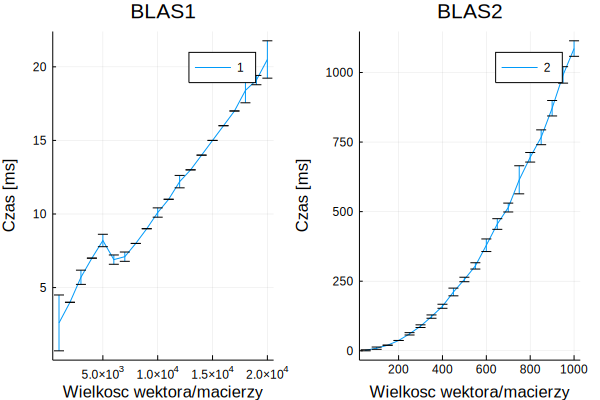

In [7]:
# import Pkg
# Pkg.add("DataFrames")
# Pkg.add("CSV")
# Pkg.add("Plots")
# Pkg.add("StatsBase")
using DataFrames
using CSV
using Plots
using StatsBase
using Statistics
df1 = DataFrame()
input = "largecsv.csv"
df1 = CSV.read(input, delim = ","; datarow=2)
df1[:Mean] = [mean(df1[x, 3:12]) for x in 1:40]
df1[:Std] = [std(df1[x, 3:12]) for x in 1:40]
plot(df1[1:40, :SIZE], df1[1:40, :Mean], group=df1[:BLAS], yerr=df1[1:40, :Std], layout=2, title = ["BLAS1" "BLAS2"],
        xlabel = "Wielkosc wektora/macierzy", ylabel = "Czas [ms]",)